In [ ]:
# Import Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/holdout.zip
!unzip -q /content/mini_holdout.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm holdout.zip
!rm mini_holdout.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [ ]:
# !pip install coremltools

In [ ]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# import coremltools
import os
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.


training_dir = '/content/training/'
image_size = (224, 224)  # ResNet50 expects 224x224 images

# Split up the training data images into training and validation sets
# We'll use an ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and augmentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
        rotation_range=20
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42, shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)


Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [ ]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Crossroad_Ahead', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'Cars_Prohibited(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Bends_Left_Then_Right', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Uncontrolled_Crossroad', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

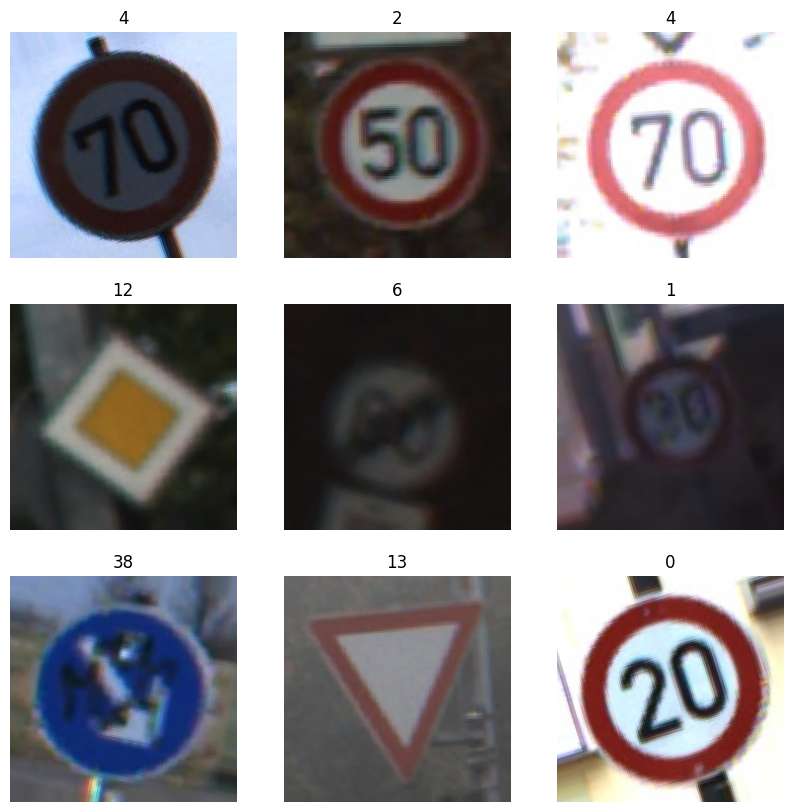

In [ ]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

# Training the model using ResNet50

In [ ]:
# Define the path where you want to save your model
save_path = '/content/drive/My Drive/model_checkpoints/'

# Create the directory if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(save_path, 'master_epoch_{epoch:02d}.h5'),
    save_weights_only=False,  # Set to True if you only want to save model weights
    save_best_only=False,     # Set to True to save only the best model based on the monitored metric
    save_freq='epoch',        # Save after every epoch
    verbose=1                 # Print a message when saving
)

# Load the ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)  # Add dropout for regularization
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x) # delete kernal_regularization if model fails
x = GaussianNoise(0.1)(x)
predictions = Dense(len(target_names), activation='softmax')(x)  # Assuming the number of classes is 43

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,  # Adjust the number of epochs as needed
    callbacks=[checkpoint_callback]
)

94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/10
980/980 [==============================] - ETA: 0s - loss: 1.5300 - accuracy: 0.8791
Epoch 1: saving model to /content/drive/My Drive/model_checkpoints/master_epoch_01.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


980/980 [==============================] - 596s 562ms/step - loss: 1.5300 - accuracy: 0.8791 - val_loss: 0.6956 - val_accuracy: 0.8687
Epoch 2/10
980/980 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.9714
Epoch 2: saving model to /content/drive/My Drive/model_checkpoints/master_epoch_02.h5
980/980 [==============================] - 551s 562ms/step - loss: 0.3139 - accuracy: 0.9714 - val_loss: 0.3670 - val_accuracy: 0.9468
Epoch 3/10
980/980 [==============================] - ETA: 0s - loss: 0.2726 - accuracy: 0.9800
Epoch 3: saving model to /content/drive/My Drive/model_checkpoints/master_epoch_03.h5
980/980 [==============================] - 567s 579ms/step - loss: 0.2726 - accuracy: 0.9800 - val_loss: 0.2227 - val_accuracy: 0.9710
Epoch 4/10
980/980 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.9801
Epoch 4: saving model to /content/drive/My Drive/model_checkpoints/master_epoch_04.h5
980/980 [==============================] - 557s 5

# Saving and Loading the model

In [ ]:
# Define the path to save the model
model_path = '/content/drive/My Drive/Machine Learning Group 5/Signs (CNN)/mastre_resnet.h5'

# Save the model
model.save(model_path)

In [ ]:
from tensorflow.keras.models import load_model

# Define the path to the saved model
model_path = '/content/drive/My Drive/Machine Learning Group 5/Signs (CNN)/mastre_resnet.h5'

# Load the model
model = load_model(model_path)

# Saving the model as CoreML (Apple)

As part of the module, they asked for a model that worked with Apple's kit, so this is a just in case we need it.


In [ ]:
# core_model = coremltools.convert(model, convert_to="mlprogram", inputs=[coremltools.TensorType(shape=[1, 224, 224, 3])])

# model.save("/content/drive/My Drive/Machine Learning Group 5/Signs (CNN)/resnet50_roadsigns.mlprogram")

# Plotting the model

In [ ]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# Generate predictions
val_generator = validation_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='sparse',
    subset="validation",
    seed=42,
    shuffle=False  # Important to keep the order to match predictions with labels
)

# Predict the labels
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=target_names)
print(report)

246/246 [==============================] - 28s 106ms/step - loss: 0.2421 - accuracy: 0.9802
Validation Loss: 0.24213555455207825
Validation Accuracy: 0.9802321195602417
Found 7841 images belonging to 43 classes.
246/246 [==============================] - 25s 98ms/step
                                   precision    recall  f1-score   support

                         Speed_20       1.00      0.98      0.99        42
                         Speed_30       0.98      0.96      0.97       444
                         Speed_50       1.00      0.97      0.98       450
                         Speed_60       0.97      1.00      0.98       282
                         Speed_70       0.99      0.98      0.99       396
                         Speed_80       0.96      0.99      0.98       372
                 Speed_Limit_Ends       0.97      1.00      0.98        84
                        Speed_100       1.00      0.97      0.98       288
                        Speed_120       1.00      0.99 

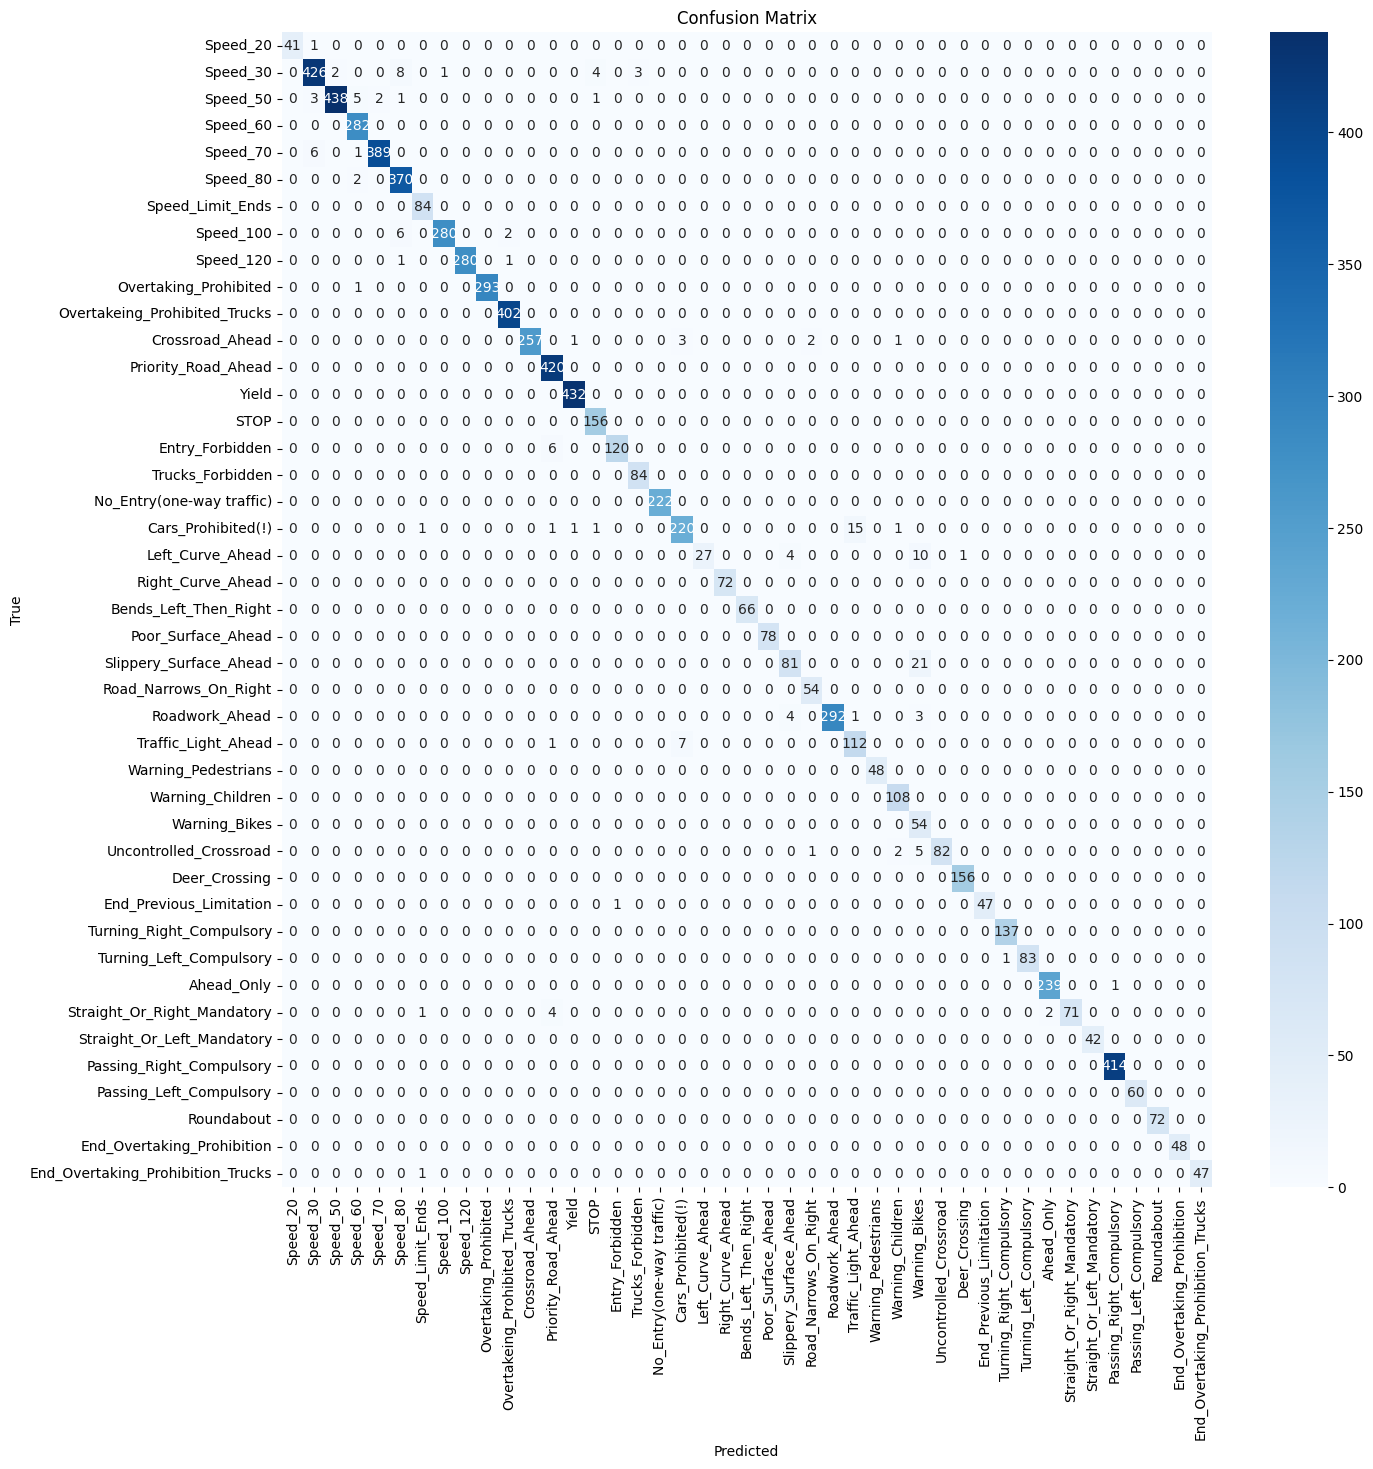

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Testing the model
Once you have built and trained your model, the next step is to run the mini holdout images through it and see how well your model does at making predictions for images it has never seen before.

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Previously, you were given a file that would check your results. This time you're given the answers to the first mini holdout dataset. You'll need to compare those predictions against the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Make sure to use the insights gained from the mini hold out dataset in your executive summary.


```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



##Mini Hold out Dataset


Once you feel confident, you will need to predict for the full holdout dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```

Found 201 images belonging to 1 classes.
7/7 [==============================] - 2s 280ms/step
Accuracy: 99.00%
Classification Report:
                               precision    recall  f1-score   support

                     Speed_30       1.00      1.00      1.00        11
                     Speed_50       1.00      1.00      1.00         8
                     Speed_60       1.00      1.00      1.00        10
                     Speed_70       1.00      1.00      1.00         9
                     Speed_80       1.00      1.00      1.00         5
             Speed_Limit_Ends       1.00      1.00      1.00         3
                    Speed_100       1.00      1.00      1.00         8
                    Speed_120       1.00      1.00      1.00         6
        Overtaking_Prohibited       1.00      1.00      1.00        10
Overtakeing_Prohibited_Trucks       0.92      1.00      0.96        12
              Crossroad_Ahead       1.00      1.00      1.00         8
          Pri

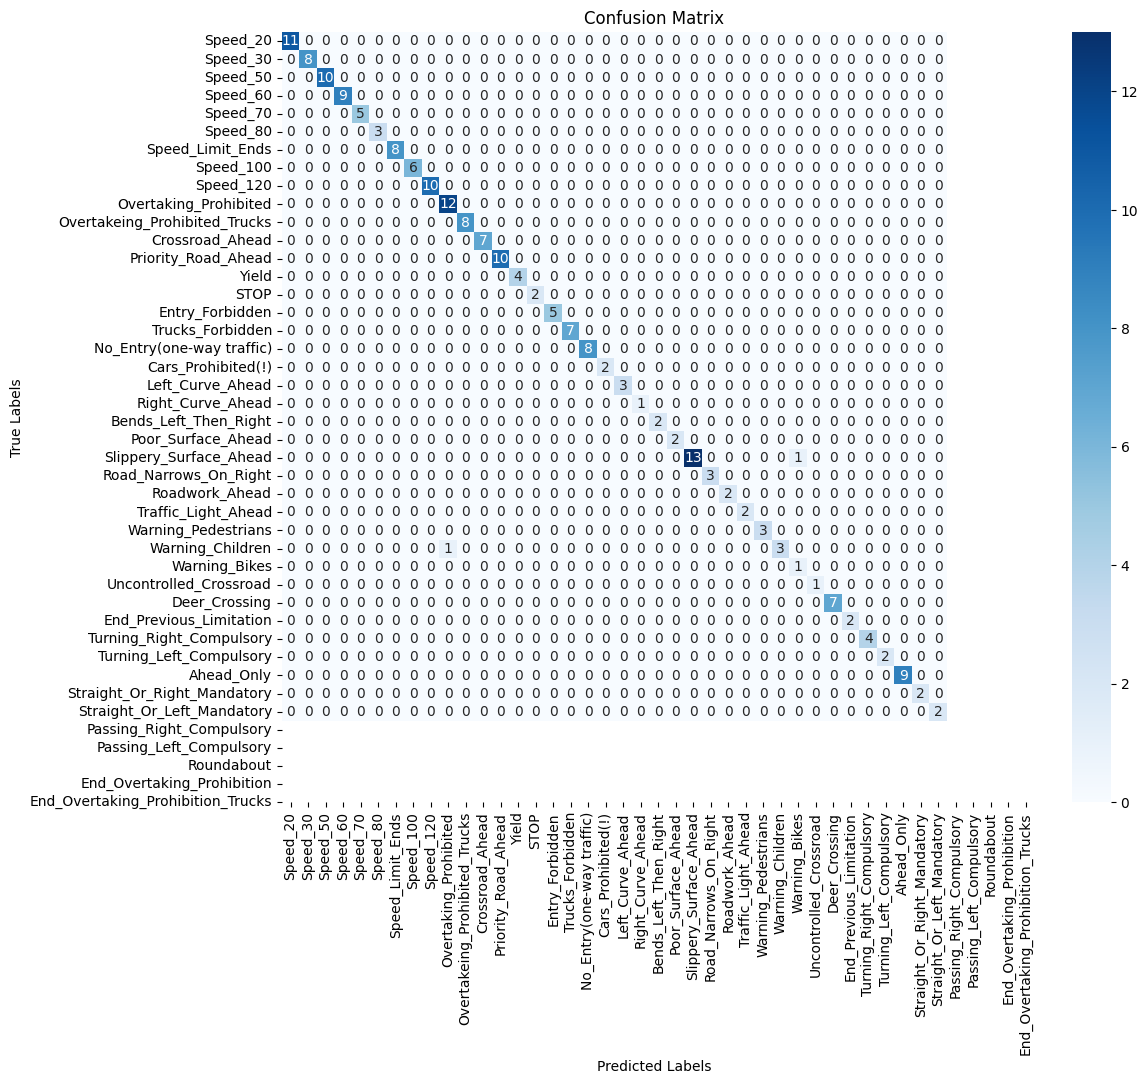

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score

# Path to the mini holdout dataset and answers file
test_dir = '/content/'
answers_file = '/content/mini_holdout_answers.csv'

# Create an ImageDataGenerator for the mini holdout dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    classes=['mini_holdout'],
    target_size=image_size,
    class_mode='sparse',
    shuffle=False,
    batch_size=32  # Adjust batch size as needed
)

# Predict probabilities for the mini holdout dataset
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]

# Load the ground truth labels from the CSV file
answers_df = pd.read_csv(answers_file)
true_labels = answers_df['ClassId'].values

# Ensure labels match actual classes present in data
unique_classes = np.unique(np.concatenate((true_labels, predictions)))
labels = sorted(unique_classes)

# Compare predictions to the ground truth
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate a classification report
report = classification_report(true_labels, predictions, labels=labels, target_names=[target_names[i] for i in labels])
print('Classification Report:')
print(report)

# Generate and display a confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]

# Ensure labels match actual classes present in data
unique_classes = np.unique(np.concatenate((true_labels, predictions)))
labels = sorted(unique_classes)

# Format and export data
predictions_table = pd.DataFrame(predictions, columns=['predictions'])
predictions_table.to_csv('team5-module5-predictions.csv', index=False)
print(predictions_table.value_counts())

Found 12630 images belonging to 1 classes.
395/395 [==============================] - 41s 103ms/step
predictions
2              746
13             724
1              717
38             684
12             670
10             667
4              662
5              644
9              493
25             486
3              453
8              450
7              447
11             425
18             389
35             386
17             333
14             275
31             240
15             228
33             222
29             200
26             183
28             181
6              159
16             150
34             125
23             123
36             117
22             110
40              96
24              96
20              91
30              87
42              87
32              79
21              74
39              73
19              60
37              59
0               55
41              53
27              31
Name: count, dtype: int64


In [ ]:
model_path = '/content/drive/My Drive/Machine Learning Group 5/Signs (CNN)/team4-module5-predictions.csv'

# Save the model
predictions_table.save(model_path)

AttributeError: 'DataFrame' object has no attribute 'save'